# Data sets Carian and Jan

   Zeit  Butanal-200  Butyroin-200  Octandiol-200  Butanal-400  Butyroin-400  \
0     0   118.424870      0.146979       0.087363   132.846287      0.146979   
1    15    34.936097     21.932372      16.156006    37.146805     42.250977   
2    30    12.690846     19.684100      41.751430    22.656304     46.116321   
3    60     6.335060     11.424406      54.491940    11.930915     44.421100   
4   120     4.728843      9.849414      59.546542     3.416235     54.099489   

   Octandiol-400  
0       0.087363  
1       2.937077  
2       3.623505  
3      10.799792  
4      32.079043  
0       0
1      15
2      30
3      60
4     120
5     260
6     360
7    1440
Name: Zeit, dtype: int64


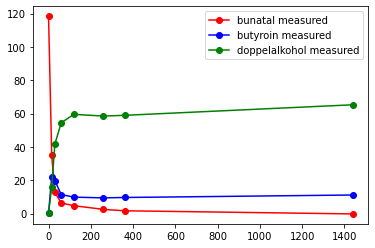

In [20]:
from scipy.integrate import odeint
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import lmfit

df = pd.read_excel(r"Jan_Carina_Daten.xlsx")

print(df.head())

butanal = df["Butanal-200"]
butyroin = df["Butyroin-200"]
octandiol = df["Octandiol-200"]

time = df["Zeit"]

print(time)

fix, ax = plt.subplots()

ax.plot(time, butanal, label="bunatal measured", color="red", linestyle="-", marker="o")
ax.plot(time, butyroin, label="butyroin measured", color="blue", linestyle="-", marker="o")
ax.plot(time, octandiol, label="doppelalkohol measured", color="green", linestyle="-", marker="o")
ax.legend()
plt.plot()
plt.show()


[[ 1.18424870e+02  3.49360967e+01  1.26908463e+01  6.33506045e+00
   4.72884283e+00  2.50086356e+00  1.67184801e+00 -2.10708117e-01]
 [ 1.46979261e-01  2.19323715e+01  1.96840998e+01  1.14244064e+01
   9.84941389e+00  9.42861437e+00  9.65103697e+00  1.11418696e+01]
 [ 8.73634945e-02  1.61560062e+01  4.17514301e+01  5.44919397e+01
   5.95465419e+01  5.85169007e+01  5.89641186e+01  6.52875715e+01]]
[150, 0, 0]
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 86
    # data points      = 24
    # variables        = 4
    chi-square         = 2283.50482
    reduced chi-square = 114.175241
    Akaike info crit   = 117.329910
    Bayesian info crit = 122.042125
[[Variables]]
    kA:  0.00130878 +/- 3.6014e-04 (27.52%) (init = 2)
    kP:  3.9477e-08 +/- 6.7691e-04 (1714669.46%) (init = 2)
    kC:  2.75885658 +/- 1.94676005 (70.56%) (init = 2)
    kD:  0.76995707 +/- 0.65408892 (84.95%) (init = 2)
[[Correlations]] (unreported correlations are < 0.100)
    C(kC, kD) =

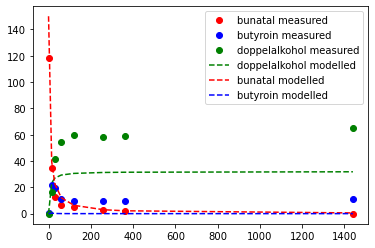

In [25]:
data_list = [butanal, butyroin, octandiol]

data = np.array(data_list)

print(data)


y0_array = [150, 0, 0]
print(y0_array)



def dbdt(kA, kB, kC, kD, A,P, C, t):
        dbdt = (kA*A**2)*0.5 - kB*P - kC*P + kD*C
        return dbdt
def dcdt(kC, kD, P, C, t):
        dcdt = kC*P - kD*C
        return dcdt




def dglsys(init_cond_array, t, kA, kB, kC, kD):
    A = init_cond_array[0]
    P = init_cond_array[1]
    C = init_cond_array[2]
    dAdt = -kA*A**2 + kB*P
    #dBdt = (kA*A**2)*0.5 - kB*P - kC*P + kD*C
    dBdt = dbdt(kA, kB, kC, kD, A, P, C, t)
    dCdt = dcdt(kC, kD, P, C, t)
    #dCdt = kC*P - kD*C
    dZdt = np.array([dAdt, dBdt, dCdt])
    return dZdt

sol = odeint(dglsys, y0_array, time, args=(0.002, 2.86, 1.06, 0.0000000896))



params = lmfit.Parameters()
params.add('kA', 2, min=0.00000001, max=3)
params.add('kP', 2, min=0.0000000001, max=3)
params.add('kC', 2, min=0.0000000001, max=3)
params.add('kD', 2, min=0.0000000001, max=3)

def residual(params, time, data_sets):
    kA = params['kA'].value
    kP = params['kP'].value
    kC = params['kC'].value
    kD = params['kD'].value
    
    ymodel=odeint(dglsys, y0_array, time, args=(kA, kP, kC, kD))
    substr = data_sets[0]-ymodel[:,0] # array 1
    product = data_sets[1]-ymodel[:,1] # array 2
    product2 = data_sets[2]-ymodel[:,2]
    result = [substr, product, product2] # result is returned as array
    return np.array(result)

solution = lmfit.minimize(residual, params, args=(np.array(time), data))
print(lmfit.report_fit(solution))


fig, ax = plt.subplots()
ax.plot(time, butanal, label="bunatal measured", color="red", linestyle="", marker="o")
ax.plot(time, butyroin, label="butyroin measured", color="blue", linestyle="", marker="o")
ax.plot(time, octandiol, label="doppelalkohol measured", color="green", linestyle="", marker="o")

ax.plot(time, sol[:,2], label="doppelalkohol modelled", linestyle="--", color="green")
ax.plot(time, sol[:,0], label="bunatal modelled", linestyle="--", color="red")
ax.plot(time, sol[:,1], label="butyroin modelled", linestyle="--", color = "blue")


ax.legend()
plt.savefig("testfig.svg", format="svg")